Teste de otimizacao dos parametros cineticos usando o algoritmo de levenberg-marquardt (LM)


Bibliotecas

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn as skl
from sklearn.metrics import root_mean_squared_error as rmse_score
from sklearn.metrics import r2_score

import scipy as scipy
from scipy.integrate import odeint
from scipy.optimize import least_squares

Funcoes usadas no programa

In [13]:
## Definicao das edos da  cinetica do microrganismo

# Função das equações diferenciais
def f_flow_opt(y, x, param):
    # Glucose, Acetic acid, Butyric acid, Acetone, Butanol, Ethanol, Biomass
    G, A, B, E, X = y

    Vmax_X = param[0]
    KS, KIB = param[1],param[2]
    Y_XS, Y_AS, Y_BS, Y_ES, Kd, alpha = param[3],param[4],param[5],param[6],param[7],param[8]

    mi_G  = Vmax_X*(G/(KS+G))*((1-(B/KIB))**alpha)-Kd

    dGdt = -X*mi_G*(1/Y_XS)
    dXdt = X*mi_G

    dBdt = X*mi_G*(Y_BS/Y_XS)
    dAdt = X*mi_G*(Y_AS/Y_XS)
    dEdt = X*mi_G*(Y_ES/Y_XS)

    return np.array([dGdt, dAdt, dBdt, dEdt, dXdt])

In [14]:
### Calculo dos parametros de erro
def func_residuo(param, x, x_exp, y_exp, y_ini):

    #print("tipo de param em func_residuo:",type(param))
    #print("param em func_residuo:",param)
    # Extrai os parâmetros
    Vmax_X = param[0]
    KS, KIB = param[1],param[2]
    Y_XS, Y_AS, Y_BS, Y_ES, Kd, alpha = param[3],param[4],param[5],param[6],param[7],param[8]
    # Integra as EDOs com os parâmetros atuais
    #solucao_modelo = odeint(modelo_sir, y0_inicial, tempo, args=(param))
    y_predicted = odeint(f_flow_opt, y_ini, x, args=(param,))
    # Conversão para arrays numpy
    #x = np.array(x)
    #print("y_predicted_head em func_residuo:",y_predicted[1:5,0])
    n_pontos = len(x_exp)
    yG_pred  = [0]*n_pontos # Glicose
    #yAA_pred = [0]*n_pontos # Acetato
    #yBA_pred = [0]*n_pontos # Butirato
    yA_pred  = [0]*n_pontos # Acetona
    yB_pred  = [0]*n_pontos # Butanol
    yE_pred  = [0]*n_pontos # Etanol
    yX_pred  = [0]*n_pontos # Biomassa

    # Glucose, Acetic acid, Butyric acid, Acetone, Butanol, Ethanol, Biomass
    cont = 0;
    ind = 0
    while cont<n_pontos:
      if round(x[ind],4)==x_exp[cont]:
        yG_pred[cont]  = np.array(y_predicted[ind,0]) # Glucose
        yA_pred[cont]  = np.array(y_predicted[ind,1]) # Acetone
        yB_pred[cont]  = np.array(y_predicted[ind,2]) # Butanol
        yE_pred[cont]  = np.array(y_predicted[ind,3]) # Ethanol
        yX_pred[cont]  = np.array(y_predicted[ind,4]) # Biomass
        cont=cont+1
      ind=ind+1

    # Calcula os resíduos para cada variável e os concatena
    # É crucial que o array de resíduos seja 1D para least_squares
    resid_yG  = y_exp[0,:] - yG_pred
    resid_yA  = y_exp[1,:] - yA_pred
    resid_yB  = y_exp[2,:] - yB_pred
    resid_yE  = y_exp[3,:] - yE_pred
    resid_yX  = (y_exp[4,:]- yX_pred)*10

    # Retorna um único array 1D com todos os resíduos
    resid = np.concatenate((resid_yG,resid_yA,resid_yB,resid_yE,resid_yX))
    return resid

In [15]:
# Calcular os parametros de erro R2 e RMSE
def func_crit_erro (x_exp, y_exp,x, y_predicted):

  n_pontos = len(x_exp)
  yG_pred  = [0]*n_pontos # Glucose
  yA_pred  = [0]*n_pontos # Acetone
  yB_pred  = [0]*n_pontos # Butanol
  yE_pred  = [0]*n_pontos # Ethanol
  yX_pred  = [0]*n_pontos # Biomass

  cont = 0;
  ind = 0
  while cont<n_pontos:
    if round(x[ind],4)==x_exp[cont]:
      yG_pred[cont]  = np.array(y_predicted[ind,0]) # Glucose
      yA_pred[cont]  = np.array(y_predicted[ind,1]) # Acetone
      yB_pred[cont]  = np.array(y_predicted[ind,2]) # Butanol
      yE_pred[cont]  = np.array(y_predicted[ind,3]) # Ethanol
      yX_pred[cont]  = np.array(y_predicted[ind,4]) # Biomass
      cont=cont+1
    ind=ind+1
  #print("tipo de y_exp:",y_exp[0,:])
  rmse_yG = rmse_score(y_exp[0,:],yG_pred)
  r2_yG = r2_score(y_exp[0,:],yG_pred)

  rmse_yA = rmse_score(y_exp[1,:],yA_pred)
  r2_yA = r2_score(y_exp[1,:],yA_pred)

  rmse_yB = rmse_score(y_exp[2,:],yB_pred)
  r2_yB = r2_score(y_exp[2,:],yB_pred)

  rmse_yE = rmse_score(y_exp[3,:],yE_pred)
  r2_yE = r2_score(y_exp[3,:],yE_pred)

  rmse_yX = rmse_score(y_exp[4,:],yX_pred)
  r2_yX = r2_score(y_exp[4,:],yX_pred)

  r2_comp = (r2_yG,r2_yA,r2_yB,r2_yE,r2_yX)
  rmse_comp = (rmse_yG,rmse_yA,rmse_yB,rmse_yE,rmse_yX)
  return r2_comp,rmse_comp

Definicao dos dados experimentos e dos artigos usados na comparacao

In [16]:
address = "/content/drive/MyDrive/_Doutorado/Tese_Bruno Ferreira_LOPCA Ferm/Congressos/IConBM2026 (Em preparo)/modelos/Ferm_results.xlsx"

In [17]:
dados = pd.read_excel(address,sheet_name="PVC01")
#dados = pd.read_excel(address,sheet_name="01")

dados=np.array(dados)
#0-"Time (h)"/1-"Glucose"/2-"Xylose"/3-"Glycerol"/4-"Acetic acid"/5-"1,3-PDO"/6-"Ethanol"/7-"Butyric acid"/8-"Acetone"/9-"Butanol"/10-"ABE"/11-"DO"/12-"X"

In [18]:
experimental_data = {
    'time': dados[:,0],
    'glucose': dados[:,1],
    'xylose': dados[:,2],
    'acetic acid': dados[:,4],
    'ethanol': dados[:,6],
    'butyric acid': dados[:,7],
    'acetone': dados[:,8],
    'butanol': dados[:,9],
    'ABE': dados[:,10],
    'biomass': dados[:,12],
}

Valores de chute inicial para a otimizacao

In [19]:
# intervalo de tempo da simulacao
h = 0.001
x=np.arange(0.0, 96.0+h, h)

# insercao dos chutes iniciais de cada parametro
param_ini=[1.29987172e+00,
            1.19e+02, 6.43e+00,
            7.10e-02, 3.97e-02, 1.73e-01, 2.86e-02, 1.00e-04, 1.49e+00]
param_ini=np.array(param_ini)

lista_param_ID = ["Vmax_X",
                  "Ks","KIB",
                  "Y_XS","Y_AS","Y_BS","Y_ES","Kd","alpha"]

#### valores inicias das substancias (1 para cada EDO)
y_ini=np.array([experimental_data['glucose'][0],experimental_data['acetone'][0],experimental_data['butanol'][0],experimental_data['ethanol'][0],experimental_data['biomass'][0]])

#extracao dos dados experimentais para serem passados as funcoes
y_exp=np.array([experimental_data['glucose'], experimental_data['acetone'],experimental_data['butanol'],experimental_data['ethanol'],experimental_data['biomass']])
x_exp=np.array(experimental_data['time'])

Otimizacao dos parametros das EDOs

In [20]:
#print("param otm:", param_optm)
bd_inf = [0.2,
          20,5.5,
          0.07,0.02,0.05,0.02,0.0001,0.1]
bd_sup = [1.3,
          120,11.0,
          0.11,0.20,0.40,0.10,0.3000,1.5]

resultado = least_squares(func_residuo, param_ini,args=(x, x_exp, y_exp, y_ini), bounds=(bd_inf, bd_sup)) # 'lm' para Levenberg-Marquardt
param_optm = resultado.x
print("param init:", param_ini)
print("param optm:", param_optm)

param init: [1.29987172e+00 1.19000000e+02 6.43000000e+00 7.10000000e-02
 3.97000000e-02 1.73000000e-01 2.86000000e-02 1.00000000e-04
 1.49000000e+00]
param optm: [1.30000000e+00 1.19996291e+02 6.43321875e+00 7.10342454e-02
 3.97634506e-02 1.73277825e-01 2.86659906e-02 1.00000000e-04
 1.50000000e+00]


In [21]:
print("Comparison between the initial and optimized parameters values:\n")
for i in range(len(param_ini)):
  diff = param_ini[i] - param_optm[i]
  perc_dif = diff/param_ini[i]*100
  print("Initial: ", param_ini[i], " - Optimized: ",round(param_optm[i],4),
        " - Diff: ",round(diff,4)," - % dif: ",round(perc_dif,2)," %",
        " - Parameter ID ", lista_param_ID[i])

Comparison between the initial and optimized parameters values:

Initial:  1.29987172  - Optimized:  1.3  - Diff:  -0.0001  - % dif:  -0.01  %  - Parameter ID  Vmax_X
Initial:  119.0  - Optimized:  119.9963  - Diff:  -0.9963  - % dif:  -0.84  %  - Parameter ID  Ks
Initial:  6.43  - Optimized:  6.4332  - Diff:  -0.0032  - % dif:  -0.05  %  - Parameter ID  KIB
Initial:  0.071  - Optimized:  0.071  - Diff:  -0.0  - % dif:  -0.05  %  - Parameter ID  Y_XS
Initial:  0.0397  - Optimized:  0.0398  - Diff:  -0.0001  - % dif:  -0.16  %  - Parameter ID  Y_AS
Initial:  0.173  - Optimized:  0.1733  - Diff:  -0.0003  - % dif:  -0.16  %  - Parameter ID  Y_BS
Initial:  0.0286  - Optimized:  0.0287  - Diff:  -0.0001  - % dif:  -0.23  %  - Parameter ID  Y_ES
Initial:  0.0001  - Optimized:  0.0001  - Diff:  -0.0  - % dif:  -0.0  %  - Parameter ID  Kd
Initial:  1.49  - Optimized:  1.5  - Diff:  -0.01  - % dif:  -0.67  %  - Parameter ID  alpha


Calculo dos criterios de erro para os modelos com os parametros otimizados

In [22]:
y_pred_art = odeint(f_flow_opt, y_ini, x, args=(param_ini,))

r2_a,rmse_a = func_crit_erro (x_exp, y_exp,x, y_pred_art)
print("\n","\033[1mPerformance criteria results for the initial guess:\033[0m")
print("\nparam:", param_ini)
print("\033[1mR2\033[0m","\nGlucose:", str(round(r2_a[0],3)),"\tButanol:", str(round(r2_a[2],3)),"\tBiomass:", str(round(r2_a[4],3)),
      "\nAcetone:", str(round(r2_a[1],3)),"\tEthanol:", str(round(r2_a[3],3)))
print("\033[1mRMSE\033[0m","\nGlucose:", str(round(rmse_a[0],3)),"\tButanol:", str(round(rmse_a[2],3)),"\tBiomass:", str(round(rmse_a[4],3)),
      "\nAcetone:", str(round(rmse_a[1],3)),"\tEthanol:", str(round(rmse_a[3],3)))


#param_optm=param_ini
y_pred_otm = odeint(f_flow_opt, y_ini, x, args=(param_optm,))
r2,rmse = func_crit_erro (x_exp, y_exp,x, y_pred_otm)
print("\n","\033[1mPerformance criteria results for the optimized parameters:\033[0m")
print("\nparam:", param_optm)
print("\033[1mR2\033[0m","\nGlucose:", str(round(r2[0],3)),"\tButanol:", str(round(r2[2],3)),"\tBiomass:", str(round(r2[4],3)),
      "\nAcetone:", str(round(r2[2],3)),"\tEthanol:", str(round(r2[3],3)))
print("\033[1mRMSE\033[0m","\nGlucose:", str(round(rmse[0],3)),"\tButanol:", str(round(rmse[2],3)),"\tBiomass:", str(round(rmse[4],3)),
      "\nAcetone:", str(round(rmse[1],3)),"\tEthanol:", str(round(rmse[3],3)))

#print(y_pred_art-y_pred_otm)


 Performance criteria results for the initial guess:

param: [1.29987172e+00 1.19000000e+02 6.43000000e+00 7.10000000e-02
 3.97000000e-02 1.73000000e-01 2.86000000e-02 1.00000000e-04
 1.49000000e+00]
R2 
Glucose: 0.977 	Butanol: 0.791 	Biomass: 0.839 
Acetone: 0.388 	Ethanol: 0.57
RMSE 
Glucose: 2.506 	Butanol: 1.566 	Biomass: 0.418 
Acetone: 0.903 	Ethanol: 0.418

 Performance criteria results for the optimized parameters:

param: [1.30000000e+00 1.19996291e+02 6.43321875e+00 7.10342454e-02
 3.97634506e-02 1.73277825e-01 2.86659906e-02 1.00000000e-04
 1.50000000e+00]
R2 
Glucose: 0.977 	Butanol: 0.793 	Biomass: 0.838 
Acetone: 0.793 	Ethanol: 0.572
RMSE 
Glucose: 2.464 	Butanol: 1.557 	Biomass: 0.42 
Acetone: 0.902 	Ethanol: 0.416


Graficos comparando os dados exp, e os modelos do artigo e otimizado

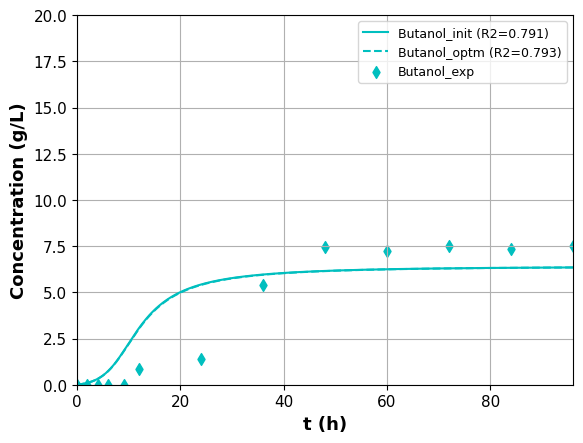

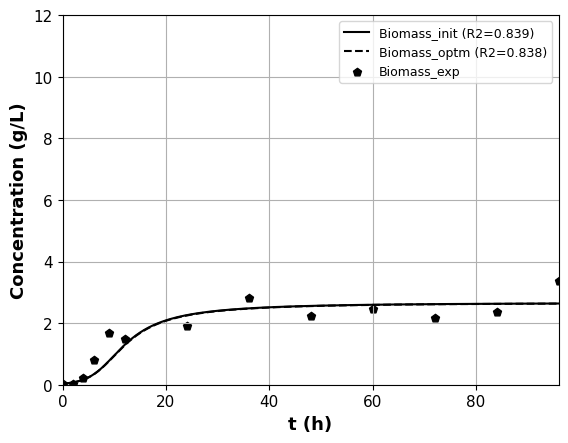

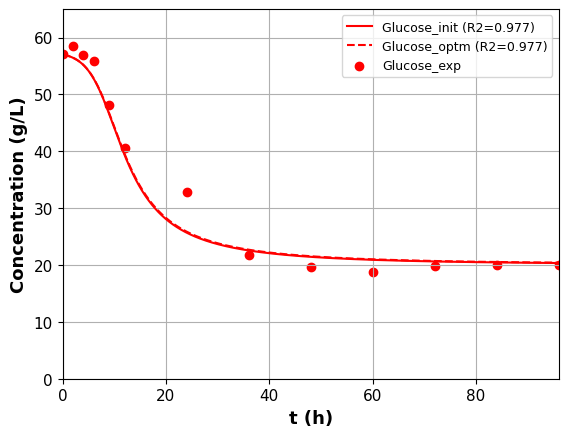

In [23]:
# Gráficos dos fluxos molares

fz_labels = 13
fz_title = 15
fz_ticks = 11
fz_lgd = 9

plt.figure()
plt.plot(x, y_pred_art[:,2], label='Butanol_init (R2='+str(round(r2_a[2],3))+")",color='c', linestyle='-')
plt.plot(x, y_pred_otm[:,2], label='Butanol_optm (R2='+str(round(r2[2],3))+")",color='c', linestyle='--')
plt.scatter(x_exp, y_exp[2,:],label='Butanol_exp',color='c', marker='d')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,20.])
plt.legend(bbox_to_anchor=(1., 1.), fontsize=fz_lgd)
plt.grid()

plt.figure()
plt.plot(x, y_pred_art[:,4], label='Biomass_init (R2='+str(round(r2_a[4],3))+")",color='k', linestyle='-')
plt.plot(x, y_pred_otm[:,4], label='Biomass_optm (R2='+str(round(r2[4],3))+")",color='k', linestyle='--')
plt.scatter(x_exp, y_exp[4,:],label='Biomass_exp', color='k', marker='p')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,12.])
plt.legend(fontsize=fz_lgd)
plt.grid()

plt.figure()
plt.plot(x, y_pred_art[:,0], label='Glucose_init (R2='+str(round(r2_a[0],3))+")",color='red', linestyle='-')
plt.plot(x, y_pred_otm[:,0], label='Glucose_optm (R2='+str(round(r2[0],3))+")",color='red', linestyle='--')
plt.scatter(x_exp, y_exp[0,:],label='Glucose_exp',color='red', marker='o')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,65.])
plt.legend(fontsize=fz_lgd)
plt.grid()

plt.show()

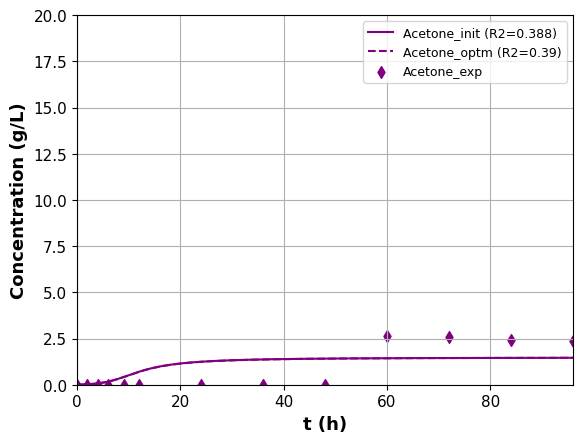

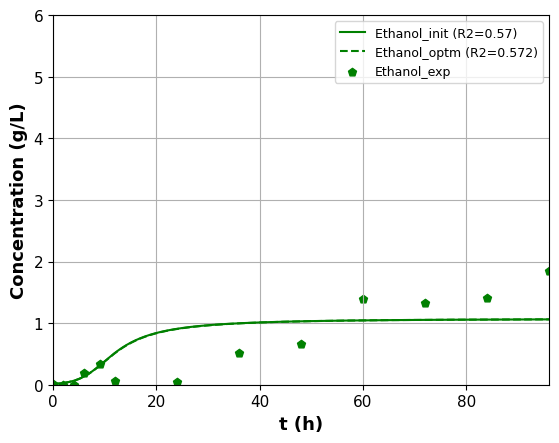

In [24]:
# Gráficos dos fluxos molares

fz_labels = 13
fz_title = 15
fz_ticks = 11
fz_lgd = 9

plt.figure()
plt.plot(x, y_pred_art[:,1], label='Acetone_init (R2='+str(round(r2_a[1],3))+")",color='purple', linestyle='-')
plt.plot(x, y_pred_otm[:,1], label='Acetone_optm (R2='+str(round(r2[1],3))+")",color='purple', linestyle='--')
plt.scatter(x_exp, y_exp[1,:],label='Acetone_exp',color='purple', marker='d')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,20.])
plt.legend(bbox_to_anchor=(1., 1.), fontsize=fz_lgd)
plt.grid()

plt.figure()
plt.plot(x, y_pred_art[:,3], label='Ethanol_init (R2='+str(round(r2_a[3],3))+")",color='g', linestyle='-')
plt.plot(x, y_pred_otm[:,3], label='Ethanol_optm (R2='+str(round(r2[3],3))+")",color='g', linestyle='--')
plt.scatter(x_exp, y_exp[3,:],label='Ethanol_exp', color='g', marker='p')
plt.xlabel('t (h)',fontweight='bold', fontsize=fz_labels)
plt.ylabel('Concentration (g/L)',fontweight='bold', fontsize=fz_labels)
#plt.title('Concentração dos produtos durante a fermentação')
plt.tick_params(labelsize=fz_ticks)
plt.tick_params(labelsize=fz_ticks)
plt.xlim([0,96.])
plt.ylim([0,6.])
plt.legend(fontsize=fz_lgd)
plt.grid()

plt.show()